In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import HTML
import time

In [2]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

### Loading and Preparing the Neighborhoods Data for New York City

#### Loading Neighborhood Data for New York City 

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
nyc_neighborhoods_data = newyork_data['features']
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transforming the JSON Data into a Pandas Dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
nyc_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


However, in this dataframe, there are neighborhoods that share the same name but are located in different boroughs as shown below:

In [9]:
nnvc = nyc_neighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Chelsea        2
Murray Hill    2
Sunnyside      2
Bay Terrace    2
Name: Neighborhood, dtype: int64

In [10]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == 'Bay Terrace']

Borough Neighborhood   Latitude  Longitude
175         Queens  Bay Terrace  40.782843 -73.776802
235  Staten Island  Bay Terrace  40.553988 -74.139166

To deal with this case, we will include the borough name in the name of these neighborhoods. For example, "Bay Terrace" neighborhood which is located in "Staten Island" borough will be named "Bay Terrace, Staten Island" and the one in "Queens" will be named "Bay Terrace, Queens":

In [11]:
for i in range(nyc_neighborhoods.shape[0]):
    nyn_ = nyc_neighborhoods.loc[i, 'Neighborhood']
    if nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = nyc_neighborhoods.loc[j, 'Borough']
            nyc_neighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [12]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'].str.startswith('Bay Terrace')]

Borough                Neighborhood   Latitude  Longitude
175         Queens         Bay Terrace, Queens  40.782843 -73.776802
235  Staten Island  Bay Terrace, Staten Island  40.553988 -74.139166

#### Using `geopy` Library to get the Coordinates of New York City

In [13]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Creating a Map of New York City with neighborhoods Superimposed on Top.

In [14]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10, 
                         min_zoom=9, max_zoom=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['Borough'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#ffb300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Retrieving Venue Data For New York City

In [15]:
# Foursquare API credentials
CLIENT_ID = 'A1VPXW0G4VZLCKIMZUOGCWBXBGIY5UP21CRGT0R4OJXJOWBQ' 
CLIENT_SECRET = 'HK051UQF5HLYE5044ZAZ3R00GBQS05DCO25UV24Y531IYBQT' 
VERSION = '20180605'

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """
    A function that retrieves information about venues in each neighborhood.
    It takes as input a list of the names of the neighborhoods, a list of 
    their latitudes, and a list of their longitudes.
    It returns a dataframe with information about each neighborhood and its venues.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('•', end='')
            
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('X', end='')
                results = None
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [17]:
nyc_venues = getNearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                             latitudes=nyc_neighborhoods['Latitude'],
                             longitudes=nyc_neighborhoods['Longitude']
                            )

••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [18]:
# Removing records where venue is "building" or "office"
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(nyc_venues.shape)
nyc_venues.head()

(23375, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0                  Shell       40.894187       -73.845862         Gas Station  
1       Lollipops Gelato       40.894123       -73.845892        Dessert Shop  
2            Pitman Deli       40.894149       -73.845748                Food  
3  Julio C Barber Shop 2       40.894165       -73.845748  Salon / Barbershop  
4       Public School 87       40.895331       -73.845918              School

#### Let's check how many venues were returned for each neighborhood

In [19]:
nyc_venues.groupby('Neighborhood').size()

Neighborhood
Allerton                      81
Annadale                      77
Arden Heights                 65
Arlington                     71
Arrochar                      74
Arverne                       79
Astoria                       72
Astoria Heights               60
Auburndale                    59
Bath Beach                    82
Battery Park City             88
Bay Ridge                     77
Bay Terrace, Queens           80
Bay Terrace, Staten Island    75
Baychester                    81
Bayside                       84
Bayswater                     74
Bedford Park                  70
Bedford Stuyvesant            88
Beechhurst                    86
Bellaire                      78
Belle Harbor                  78
Bellerose                     72
Belmont                       51
Bensonhurst                   80
Bergen Beach                  78
Blissville                    77
Bloomfield                    71
Boerum Hill                   84
Borough Park                  

In [20]:
nyc_neighborhoods.shape[0], nyc_venues['Neighborhood'].unique().shape[0]

(306, 306)

We notice that there are 300 neighborhoods in the table while we had 306 neighborhoods before we got the data from Foursquare. This means that Foursquare didn't return any venue for a few neighborhoods.

In [21]:
nyc_excluded_neighborhoods = set(nyc_neighborhoods['Neighborhood']).difference(nyc_venues['Neighborhood'])
nyc_excluded_neighborhoods

set()

#### Let's find out how many unique categories can be curated from all the returned venues

In [22]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 574 uniques categories.


#### Performing one-hot on the venue category variable

In [23]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
nyc_onehot['Neighborhood_'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Advertising Agency  \
0     Wakefield    0                  0              0                   0   
1     Wakefield    0                  0              0                   0   
2     Wakefield    0                  0              0                   0   
3     Wakefield    0                  0              0                   0   
4     Wakefield    0                  0              0                   0   

   Afghan Restaurant  African Restaurant  Airport  Airport Gate  \
0                  0                   0        0             0   
1                  0                   0        0             0   
2                  0                   0        0             0   
3                  0                   0        0             0   
4                  0                   0        0             0   

   Airport Lounge  Airport Terminal  Airport Tram  Alternative Healer  \
0               0                 0             0                   0   
1               0                 0             0                   0   
2               0                 0             0                   0   
3               0                 0             0                   0   
4               0                 0             0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Arcade  \
0                    0               0             0       0   
1                    0               0             0       0   
2                    0               0             0       0   
3                    0               0             0       0   
4                    0               0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   

   Assisted Living  Astrologer  Athletics & Sports  Auditorium  \
0                0           0                   0           0   
1                0           0                   0           0   
2                0           0                   0           0   
3                0           0                   0           0   
4                0           0                   0           0   

   Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0                0            0              0                0          0   
1                0            0              0                0          0   
2                0            0              0                0          0   
3                0            0              0                0          0   
4                0            0              0                0          0   

   Baby Store  Bagel Shop  Baggage Locker  Bakery  Ballroom  Bank  Bar  \
0           0           0               0       0         0     0    0   
1           0           0               0       0         0     0    0   
2           0           0               0       0         0     0    0   
3           0           0               0       0         0     0    0   
4           0           0               0       0         0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Bath House  \
0               0       

#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [24]:
nyc_grouped = nyc_onehot.groupby('Neighborhood_').mean().reset_index()
nyc_grouped.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Advertising Agency  \
0       Allerton  0.0                0.0            0.0                 0.0   
1       Annadale  0.0                0.0            0.0                 0.0   
2  Arden Heights  0.0                0.0            0.0                 0.0   
3      Arlington  0.0                0.0            0.0                 0.0   
4       Arrochar  0.0                0.0            0.0                 0.0   

   Afghan Restaurant  African Restaurant  Airport  Airport Gate  \
0                0.0                 0.0      0.0           0.0   
1                0.0                 0.0      0.0           0.0   
2                0.0                 0.0      0.0           0.0   
3                0.0                 0.0      0.0           0.0   
4                0.0                 0.0      0.0           0.0   

   Airport Lounge  Airport Terminal  Airport Tram  Alternative Healer  \
0             0.0               0.0           0.0                 0.0   
1             0.0               0.0           0.0                 0.0   
2             0.0               0.0           0.0                 0.0   
3             0.0               0.0           0.0                 0.0   
4             0.0               0.0           0.0                 0.0   

   American Restaurant  Animal Shelter  Antique Shop    Arcade  \
0             0.000000             0.0           0.0  0.000000   
1             0.038961             0.0           0.0  0.000000   
2             0.000000             0.0           0.0  0.000000   
3             0.028169             0.0           0.0  0.014085   
4             0.000000             0.0           0.0  0.000000   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0.0                     0.0     0.012346         0.0   
1               0.0                     0.0     0.000000         0.0   
2               0.0                     0.0     0.000000         0.0   
3               0.0                     0.0     0.000000         0.0   
4               0.0                     0.0     0.000000         0.0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0         0.0             0.000000                   0.0               0.0   
1         0.0             0.000000                   0.0               0.0   
2         0.0             0.015385                   0.0               0.0   
3         0.0             0.000000                   0.0               0.0   
4         0.0             0.000000                   0.0               0.0   

   Assisted Living  Astrologer  Athletics & Sports  Auditorium  \
0              0.0         0.0                 0.0         0.0   
1              0.0         0.0                 0.0         0.0   
2              0.0         0.0                 0.0         0.0   
3              0.0         0.0                 0.0         0.0   
4              0.0         0.0                 0.0         0.0   

   Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0              0.0          0.0            0.0         0.012346        0.0   
1              0.0          0.0            0.0         0.012987        0.0   
2              0.0          0.0            0.0         0.000000        0.0   
3              0.0          0.0            0.0         0.014085        0.0   
4              0.0          0.0            0.0         0.000000        0.0   

   Baby Store  Bagel Shop  Baggage Locker    Bakery  Ballroom      Bank  \
0         0.0    0.000000             0.0  0.000000       0.0  0.000000   
1         0.0    0.012987             0.0  0.025974       0.0  0.012987   
2         0.0    0.015385             0.0  0.000000       0.0  0.000000   
3         0.0    0.014085             0.0  0.000000       0.0  0.000000   
4         0.0    0.013514             0.0  0.000000       0.0  0.000000   

        Bar  Baseball Field  Baseball Stadium  Basketball Court  Bath 

#### The most common categories for each neighborhood

In [25]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [26]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = nyc_grouped['Neighborhood_']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

Neighborhood_     1st Most Common Category  \
0       Allerton              Laundry Service   
1       Annadale           Salon / Barbershop   
2  Arden Heights  Professional & Other Places   
3      Arlington                       Church   
4       Arrochar                Deli / Bodega   

                   2nd Most Common Category 3rd Most Common Category  \
0                        Salon / Barbershop            Deli / Bodega   
1                               Pizza Place      American Restaurant   
2                                      Park          Doctor's Office   
3  Residential Building (Apartment / Condo)           Hardware Store   
4                           Laundry Service              Pizza Place   

  4th Most Common Category 5th Most Common Category 6th Most Common Category  \
0                      Spa              Gas Station              Pizza Place   
1               Nail Salon            Tattoo Parlor                      Spa   
2                     Pool            Moving Target                     Food   
3            Boat or Ferry            Deli / Bodega               Playground   
4               Nail Salon                     Food          Doctor's Office   

      7th Most Common Category  
0                     Pharmacy  
1                       Bakery  
2             Dentist's Office  
3  Professional & Other Places  
4                          Bar

### Clustering

Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative frequency of each venue-category for each neighborhood.


In [27]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 2, 2, 2, 0, 2, 2, 2], dtype=int32)

In [28]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
nyc_merged = nyc_merged[~nyc_merged['Neighborhood_'].isin(nyc_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

nyc_merged.head() # check the last columns!

Borough Neighborhood_   Latitude  Longitude  Cluster Labels  \
0   Bronx     Wakefield  40.894705 -73.847201               1   
1   Bronx    Co-op City  40.874294 -73.829939               0   
2   Bronx   Eastchester  40.887556 -73.827806               2   
3   Bronx     Fieldston  40.895437 -73.905643               2   
4   Bronx     Riverdale  40.890834 -73.912585               0   

                   1st Most Common Category 2nd Most Common Category  \
0                                      Food            Deli / Bodega   
1  Residential Building (Apartment / Condo)                   School   
2                           Automotive Shop          Auto Dealership   
3                    College Residence Hall                Synagogue   
4  Residential Building (Apartment / Condo)                     Park   

    3rd Most Common Category         4th Most Common Category  \
0         Salon / Barbershop                      Music Venue   
1         Salon / Barbershop                           Church   
2       Caribbean Restaurant                    Metro Station   
3  College Academic Building  College Administrative Building   
4                  Synagogue               Athletics & Sports   

                   5th Most Common Category 6th Most Common Category  \
0                               Gas Station          Laundry Service   
1                           Doctor's Office                     Park   
2                               Gas Station                   Bridge   
3  Residential Building (Apartment / Condo)           Student Center   
4                                Playground         Dentist's Office   

  7th Most Common Category  
0                   Church  
1              Supermarket  
2                   Church  
3     Other Great Outdoors  
4                Beach Bar

#### Creating a map that shows the neighborhoods and their clusters

We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster of the neighborhood.

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=11)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], 
                                  nyc_merged['Neighborhood_'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

#### Examining clusters

Let's see the neighborhoods in each of the five clusters:

##### Cluster 1


In [30]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood_                  1st Most Common Category  \
1                   Co-op City  Residential Building (Apartment / Condo)   
4                    Riverdale  Residential Building (Apartment / Condo)   
13                Bedford Park  Residential Building (Apartment / Condo)   
15              Morris Heights  Residential Building (Apartment / Condo)   
20                     Melrose  Residential Building (Apartment / Condo)   
21                  Mott Haven  Residential Building (Apartment / Condo)   
25                  Morrisania  Residential Building (Apartment / Condo)   
26                   Soundview  Residential Building (Apartment / Condo)   
35              Spuyten Duyvil  Residential Building (Apartment / Condo)   
43                   Concourse  Residential Building (Apartment / Condo)   
49                  Greenpoint  Residential Building (Apartment / Condo)   
54                    Flatbush  Residential Building (Apartment / Condo)   
59            Prospect Heights  Residential Building (Apartment / Condo)   
65                 Cobble Hill  Residential Building (Apartment / Condo)   
66             Carroll Gardens  Residential Building (Apartment / Condo)   
69                 Fort Greene  Residential Building (Apartment / Condo)   
70                  Park Slope  Residential Building (Apartment / Condo)   
88   Prospect Lefferts Gardens  Residential Building (Apartment / Condo)   
89                  Ocean Hill                             Deli / Bodega   
92                     Midwood  Residential Building (Apartment / Condo)   
93         Prospect Park South  Residential Building (Apartment / Condo)   
95           East Williamsburg  Residential Building (Apartment / Condo)   
97                  South Side  Residential Building (Apartment / Condo)   
98               Ocean Parkway  Residential Building (Apartment / Condo)   
101         Washington Heights  Residential Building (Apartment / Condo)   
103           Hamilton Heights  Residential Building (Apartment / Condo)   
106                East Harlem  Residential Building (Apartment / Condo)   
108                  Yorkville  Residential Building (Apartment / Condo)   
110           Roosevelt Island  Residential Building (Apartment / Condo)   
111            Upper West Side  Residential Building (Apartment / Condo)   
119            Lower East Side  Residential Building (Apartment / Condo)   
129                    Astoria  Residential Building (Apartment / Condo)   
131            Jackson Heights  Residential Building (Apartment / Condo)   
132                   Elmhurst  Residential Building (Apartment / Condo)   
136                Kew Gardens  Residential Building (Apartment / Condo)   
139           Long Island City  Residential Building (Apartment / Condo)   
140          Sunnyside, Queens  Residential Building (Apartment / Condo)   
145                  Rego Park  Residential Building (Apartment / Condo)   
158              Fresh Meadows  Residential Building (Apartment / Condo)   
159                  Briarwood  Residential Building (Apartment / Condo)   
166                   Rochdale  Residential Building (Apartment / Condo)   
175        Bay Terrace, Queens  Residential Building (Apartment / Condo)   
186                 Ravenswood  Residential Building (Apartment / Condo)   
189                Lefrak City  Residential Building (Apartment / Condo)   
196       Forest Hills Gardens  Residential Building (Apartment / Condo)   
219                Silver Lake  Residential Building (Apartment / Condo)   
221                Ditmas Park  Residential Building (Apartment / Condo)   
224                  Park Hill  Residential Building (Apartment / Condo)   
247              Carnegie Hill  Residential Building (Apartment / Condo)   
275            Stuyvesant Town  Residential Building (Apartment / Condo)   
297                  Bronxdale  Residential Building (Apartment / Condo)   
299        Kingsbridge Heights  Residential Building (Apartment /

### Loading and Preparing the Neighborhoods Data for Toronto

#### Extracting Neighborhoods Data from a Relevant Wikipedia Page

In [31]:
tor_neighborhoodss = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)
tor_neighborhoods = tor_neighborhoodss[0]

In [32]:
tor_neighborhoods.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

In [33]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]
    )
)

The dataframe has 12 boroughs and 287 neighborhoods.


In [34]:
tor_neighborhoods.columns = ['PostalCode', 'Borough', 'Neighborhood']

In [35]:
tor_neighborhoods.head()

PostalCode           Borough      Neighborhood
0        M1A      Not assigned      Not assigned
1        M2A      Not assigned      Not assigned
2        M3A        North York         Parkwoods
3        M4A        North York  Victoria Village
4        M5A  Downtown Toronto      Harbourfront

#### Removing records where the borough is "not assigned"

In [36]:
tor_neighborhoods[tor_neighborhoods.Borough == 'Not assigned']['Neighborhood'].unique()

array(['Not assigned'], dtype=object)

In [37]:
print("There are {} records where the borough is not assigned".format(
    tor_neighborhoods[tor_neighborhoods.Borough == 'Not assigned'].shape[0]))

There are 77 records where the borough is not assigned


In [38]:
tor_neighborhoods = tor_neighborhoods[tor_neighborhoods.Borough != 'Not assigned']

#### Merging records where multiple neighborhoods share the same borough

For example, there are two neighborhoods (Harbourfront and Regent Park) that share the same postal code and the same borough (Downtown Toronto) as shown below:

In [39]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough  Neighborhood
4        M5A  Downtown Toronto  Harbourfront

In [40]:
tor_neighborhoods = (tor_neighborhoods.groupby(['PostalCode', 'Borough'])['Neighborhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())

Now let's take a look at the record of Downtown Toronto borough:

In [41]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough  Neighborhood
53        M5A  Downtown Toronto  Harbourfront

#### Dealing with the case where the neighborhood is "not assigned"

For some records in the table, there is a valid value for the borough but the neighborhood has the value "Not assigned" as shown below:

In [42]:
tor_neighborhoods[tor_neighborhoods.Neighborhood.str.contains('Not assigned')]

PostalCode       Borough  Neighborhood
85        M7A  Queen's Park  Not assigned

In [43]:
tor_neighborhoods.loc[tor_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Neighborhood'] = \
    tor_neighborhoods.loc[tor_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Borough']

Now let's take a look at the previous record:

In [44]:
tor_neighborhoods[tor_neighborhoods.Borough == "Queen's Park"]

PostalCode       Borough  Neighborhood
85        M7A  Queen's Park  Queen's Park
93        M9A  Queen's Park  Queen's Park

#### Getting Latitude and Longitude Coordinates of the Neighborhoods

In [45]:
tor_lat_lng_df = pd.read_csv('toronto_nbhds_coords.csv')

In [46]:
tor_lat_lng_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

#### Adding langitude and latitude to the neighborhoods dataframe

In [47]:
tor_neighborhoods.reset_index(drop=True, inplace=True)
tor_neighborhoods['Latitude'] = -99999.9
tor_neighborhoods['Longitude'] = -99999.9

for i in range(tor_neighborhoods.shape[0]):
    postalcode = tor_neighborhoods.loc[i, 'PostalCode']
    lat = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Latitude'].squeeze()
    lng = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Longitude'].squeeze()
    tor_neighborhoods.loc[i, 'Latitude'] = lat
    tor_neighborhoods.loc[i, 'Longitude'] = lng    

In [48]:
tor_neighborhoods.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [49]:
tor_neighborhoods.shape

(103, 5)

#### Using geopy Library to get the Coordinates of Toronto

In [50]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Creating a map of Toronto with neighborhoods superimposed on top

In [51]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,
                         min_zoom=9, max_zoom=11)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(tor_neighborhoods['Latitude'], tor_neighborhoods['Longitude'], 
                                           tor_neighborhoods['Borough'], tor_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        weight=2,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Retrieving Venue Data For Toronto

In [52]:
tor_venues = getNearbyVenues(names=tor_neighborhoods['Neighborhood'],
                             latitudes=tor_neighborhoods['Latitude'],
                             longitudes=tor_neighborhoods['Longitude']
                            )

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [53]:
# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(7705, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
1  Rouge, Malvern              43.806686              -79.194353   
2  Rouge, Malvern              43.806686              -79.194353   
4  Rouge, Malvern              43.806686              -79.194353   
5  Rouge, Malvern              43.806686              -79.194353   
6  Rouge, Malvern              43.806686              -79.194353   

                         Venue  Venue Latitude  Venue Longitude  \
1                        Shell       43.803227       -79.192414   
2              Centennial Park       43.786257       -79.148776   
4                      Wendy's       43.807448       -79.199056   
5  Rouge Park - Woodland Trail       43.801782       -79.200427   
6                 Auto Camping       43.807896       -79.199733   

         Venue Category  
1           Gas Station  
2                  Park  
4  Fast Food Restaurant  
5                 Trail  
6       Automotive Shop

#### Let's check how many venues were returned for each neighborhood

In [54]:
tor_venues.groupby('Neighborhood').size()

Neighborhood
Adelaide, King, Richmond                                                                                                                   90
Agincourt                                                                                                                                  78
Agincourt North, L'Amoreaux East, Milliken, Steeles East                                                                                   60
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown                              96
Alderwood, Long Branch                                                                                                                     79
Bathurst Manor, Downsview North, Wilson Heights                                                                                            74
Bayview Village                                                                                                                        

In [95]:
tor_neighborhoods.shape[0], tor_venues['Neighborhood'].unique().shape[0]

(103, 102)

We notice that there are 301 neighborhoods in the table while we had 306 neighborhoods before we got the data from Foursquare. This means that Foursquare didn't return any venue for 5 neighborhoods. These 5 neighborhoods are:

In [94]:
tor_excluded_neighborhoods = set(tor_neighborhoods['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

#### Let's find out how many unique categories can be curated from all the returned venues

In [57]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 500 uniques categories.


#### Performing one-hot on the venue category variable

In [58]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
1  Rouge, Malvern    0                  0              0               0   
2  Rouge, Malvern    0                  0              0               0   
4  Rouge, Malvern    0                  0              0               0   
5  Rouge, Malvern    0                  0              0               0   
6  Rouge, Malvern    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
1                   0                  0                   0        0   
2                   0                  0                   0        0   
4                   0                  0                   0        0   
5                   0                  0                   0        0   
6                   0                  0                   0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
1                   0             0               0                0   
2                   0             0               0                0   
4                   0             0               0                0   
5                   0             0               0                0   
6                   0             0               0                0   

   Airport Terminal  Alternative Healer  American Restaurant  Animal Shelter  \
1                 0                   0                    0               0   
2                 0                   0                    0               0   
4                 0                   0                    0               0   
5                 0                   0                    0               0   
6                 0                   0                    0               0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Art Gallery  Art Studio  \
1             0         0       0                 0            0           0   
2             0         0       0                 0            0           0   
4             0         0       0                 0            0           0   
5             0         0       0                 0            0           0   
6             0         0       0                 0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
1                    0                     0                 0   
2                    0                     0                 0   
4                    0                     0                 0   
5                    0                     0                 0   
6                    0                     0                 0   

   Assisted Living  Athletics & Sports  Auditorium  Auto Dealership  \
1                0                   0           0                0   
2                0                   0           0                0   
4                0                   0           0                0   
5                0                   0           0                0   
6                0                   0           0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
1            0              0                0          0           0   
2            0              0                0          0           0   
4            0              0                0          0           0   
5            0              0                0          0           0   
6            0              0                1          0           0   

   Bagel Shop  Baggage Claim  Bakery  Ballroom  Bank  Bar  Baseball Field  \
1           0              0       0         0     0    0               0   
2           0              0       0         0     0    0               0   
4           0              0       0         0     0    0               0   
5           0              0       0         0     0    0               0   
6           0              0       0         0     0    0        

#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [59]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

Neighborhood_  ATM  Accessories Store  \
0                           Adelaide, King, Richmond  0.0                0.0   
1                                          Agincourt  0.0                0.0   
2  Agincourt North, L'Amoreaux East, Milliken, St...  0.0                0.0   
3  Albion Gardens, Beaumond Heights, Humbergate, ...  0.0                0.0   
4                             Alderwood, Long Branch  0.0                0.0   

   Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
0            0.0             0.0                 0.0                0.0   
1            0.0             0.0                 0.0                0.0   
2            0.0             0.0                 0.0                0.0   
3            0.0             0.0                 0.0                0.0   
4            0.0             0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Food Court  Airport Gate  \
0                 0.0      0.0                 0.0           0.0   
1                 0.0      0.0                 0.0           0.0   
2                 0.0      0.0                 0.0           0.0   
3                 0.0      0.0                 0.0           0.0   
4                 0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  Alternative Healer  \
0             0.0              0.0               0.0                 0.0   
1             0.0              0.0               0.0                 0.0   
2             0.0              0.0               0.0                 0.0   
3             0.0              0.0               0.0                 0.0   
4             0.0              0.0               0.0                 0.0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium    Arcade  \
0             0.011111             0.0           0.0       0.0  0.000000   
1             0.012821             0.0           0.0       0.0  0.012821   
2             0.000000             0.0           0.0       0.0  0.000000   
3             0.000000             0.0           0.0       0.0  0.000000   
4             0.000000             0.0           0.0       0.0  0.000000   

   Arepa Restaurant  Art Gallery  Art Studio  Arts & Crafts Store  \
0               0.0     0.011111         0.0             0.000000   
1               0.0     0.000000         0.0             0.012821   
2               0.0     0.000000         0.0             0.016667   
3               0.0     0.062500         0.0             0.000000   
4               0.0     0.000000         0.0             0.012658   

   Arts & Entertainment  Asian Restaurant  Assisted Living  \
0                   0.0          0.022222              0.0   
1                   0.0          0.000000              0.0   
2                   0.0          0.033333              0.0   
3                   0.0          0.000000              0.0   
4                   0.0          0.025316              0.0   

   Athletics & Sports  Auditorium  Auto Dealership  Auto Garage  \
0            0.000000         0.0         0.000000     0.000000   
1            0.012821         0.0         0.000000     0.012821   
2            0.000000         0.0         0.000000     0.000000   
3            0.000000         0.0         0.000000     0.000000   
4            0.012658         0.0         0.012658     0.000000   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0            0.0         0.000000   0.011111         0.0    0.022222   
1            0.0         0.076923   0.000000         0.0    0.000000   
2            0.0         0.000000   0.050000         0.0    0.000000   
3            0.0         0.000000   0.000000         0.0    0.010417   
4            0.0         0.000000   0.025316         0.0    0.000000   

   Baggage Claim    Bakery  Ballroom      Bank       Bar  Baseball Field  \
0            0.0  0.011111  0.011111  0.000000  0.022222             0.0   
1       

#### The most common categories for each neighborhood

In [60]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [61]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category  \
0                           Adelaide, King, Richmond              Coffee Shop   
1                                          Agincourt          Automotive Shop   
2  Agincourt North, L'Amoreaux East, Milliken, St...       Chinese Restaurant   
3  Albion Gardens, Beaumond Heights, Humbergate, ...       Salon / Barbershop   
4                             Alderwood, Long Branch              Gas Station   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0                     Café                Hotel Bar       Italian Restaurant   
1                      Spa    General Entertainment       Chinese Restaurant   
2                   School          Doctor's Office           Medical Center   
3            Movie Theater         Spiritual Center              Pizza Place   
4                      Pub       Salon / Barbershop           Medical Center   

        5th Most Common Category                  6th Most Common Category  \
0  Vegetarian / Vegan Restaurant                                Food Court   
1             Salon / Barbershop  Residential Building (Apartment / Condo)   
2                      BBQ Joint                                    Church   
3                           Farm                               Art Gallery   
4                           Bank                                   Factory   

  7th Most Common Category  
0                    Hotel  
1         Malay Restaurant  
2                Bookstore  
3                   Bakery  
4           Breakfast Spot

### Clustering

Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative frequency of each venue-category for each neighborhood.


In [62]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 3, 3, 1, 3, 1], dtype=int32)

In [63]:
# add clustering labels
tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head() # check the last columns!

PostalCode      Borough                           Neighborhood_   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels                  1st Most Common Category  \
0 -79.194353               0                                   Factory   
1 -79.160497               0                           Automotive Shop   
2 -79.188711               1                         Electronics Store   
3 -79.216917               3  Residential Building (Apartment / Condo)   
4 -79.239476               1  Residential Building (Apartment / Condo)   

                   2nd Most Common Category 3rd Most Common Category  \
0                           Automotive Shop              Coffee Shop   
1                                      Park              Gas Station   
2  Residential Building (Apartment / Condo)                   Church   
3                         Indian Restaurant                 Pharmacy   
4                           Doctor's Office           Medical Center   

  4th Most Common Category 5th Most Common Category 6th Most Common Category  \
0                     Park       Salon / Barbershop          Doctor's Office   
1    General Entertainment           Medical Center       Salon / Barbershop   
2              Pizza Place       Salon / Barbershop   Thrift / Vintage Store   
3              Coffee Shop              Pizza Place        Convenience Store   
4                   Bakery        Indian Restaurant             Tennis Court   

  7th Most Common Category  
0           Medical Center  
1                    Hotel  
2                     Bank  
3                     Bank  
4          Automotive Shop

#### Creating a map that shows the neighborhoods and their clusters

We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster of the neighborhood.

In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood_'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### Examining clusters

Let's see the neighborhoods in each of the five clusters:

##### Cluster 1


In [65]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
0         Scarborough               0                  Factory   
1         Scarborough               0          Automotive Shop   
10        Scarborough               0          Automotive Shop   
12        Scarborough               0          Automotive Shop   
29         North York               0          Automotive Shop   
53   Downtown Toronto               0              Art Gallery   
71         North York               0           Clothing Store   
76       West Toronto               0          Automotive Shop   
81               York               0          Automotive Shop   
92          Etobicoke               0          Automotive Shop   
96         North York               0          Automotive Shop   
97         North York               0                  Factory   
102         Etobicoke               0                  Factory   

    2nd Most Common Category                  3rd Most Common Category  \
0            Automotive Shop                               Coffee Shop   
1                       Park                               Gas Station   
10    Furniture / Home Store                               Auto Garage   
12                       Spa                     General Entertainment   
29               Gas Station                                       Spa   
53    Furniture / Home Store                           Automotive Shop   
71    Furniture / Home Store                             Design Studio   
76                      Park                                    Church   
81               Gas Station  Residential Building (Apartment / Condo)   
92           Coworking Space                        Miscellaneous Shop   
96               Gas Station                                      Park   
97            Hardware Store                    Furniture / Home Store   
102                    Hotel                  Mediterranean Restaurant   

                     4th Most Common Category 5th Most Common Category  \
0                                        Park       Salon / Barbershop   
1                       General Entertainment           Medical Center   
10                                    Factory                   Bakery   
12                         Chinese Restaurant       Salon / Barbershop   
29                                 Restaurant            Metro Station   
53                                 Food Truck                     Park   
71                              Women's Store       Miscellaneous Shop   
76                     Furniture / Home Store    Portuguese Restaurant   
81                                Pizza Place              Event Space   
92                       Fast Food Restaurant              Social Club   
96                                     Church         Storage Facility   
97   Residential Building (Apartment / Condo)                   Church   
102               Professional & Other Places                     Café   

                     6th Most Common Category 7th Most Common Category  
0                             Doctor's Office           Medical Center  
1                          Salon / Barbershop                    Hotel  
10                              Design Studio         Storage Facility  
12   Residential Building (Apartment / Condo)         Malay Restaurant  
29                                     Lounge          Doctor's Office  
53                              Design Studio      Rental Car Location  
71                            Automotive Shop                   Arcade  
76                                    Dog Run              Gas Station  
81                                       Park          Doctor's Office  
92                       Gym / Fitness Center   Thrift / Vintage Store  
96   Residential Building (Apartment / Condo)                   Bakery  
97                                       Bank                     Park  
102                     General Entertainment              Event S

### EDA

#### Most Common Venue Categories in NYC

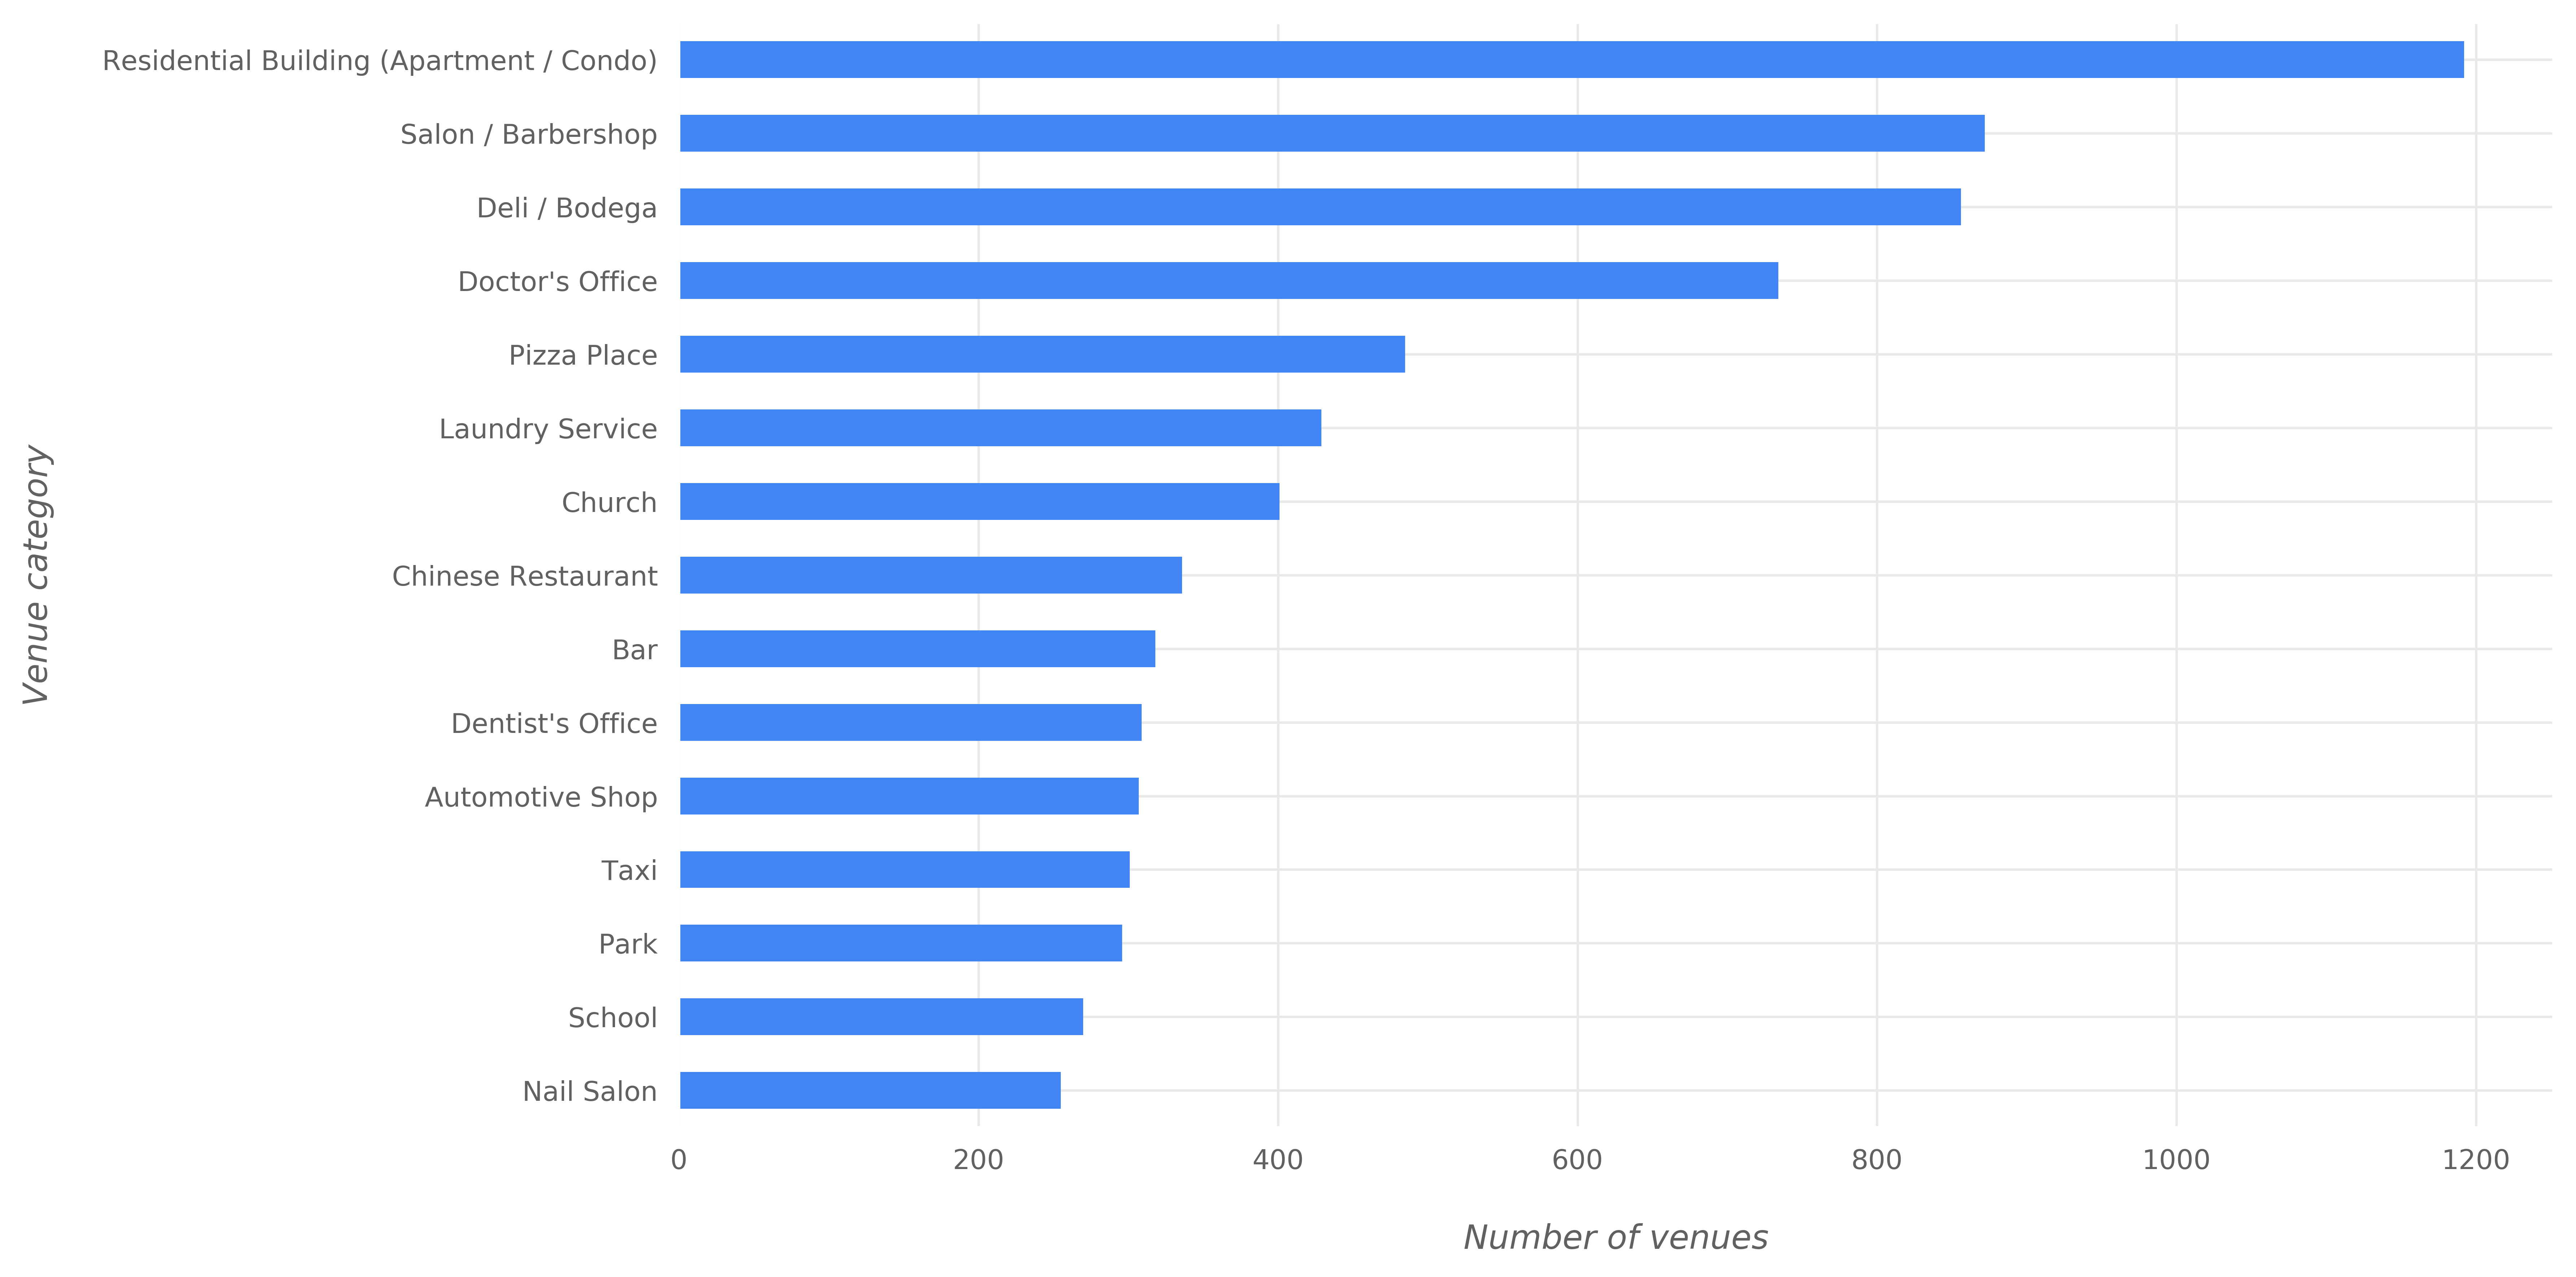

In [66]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

#### Most Common Venue Categories in Toronto

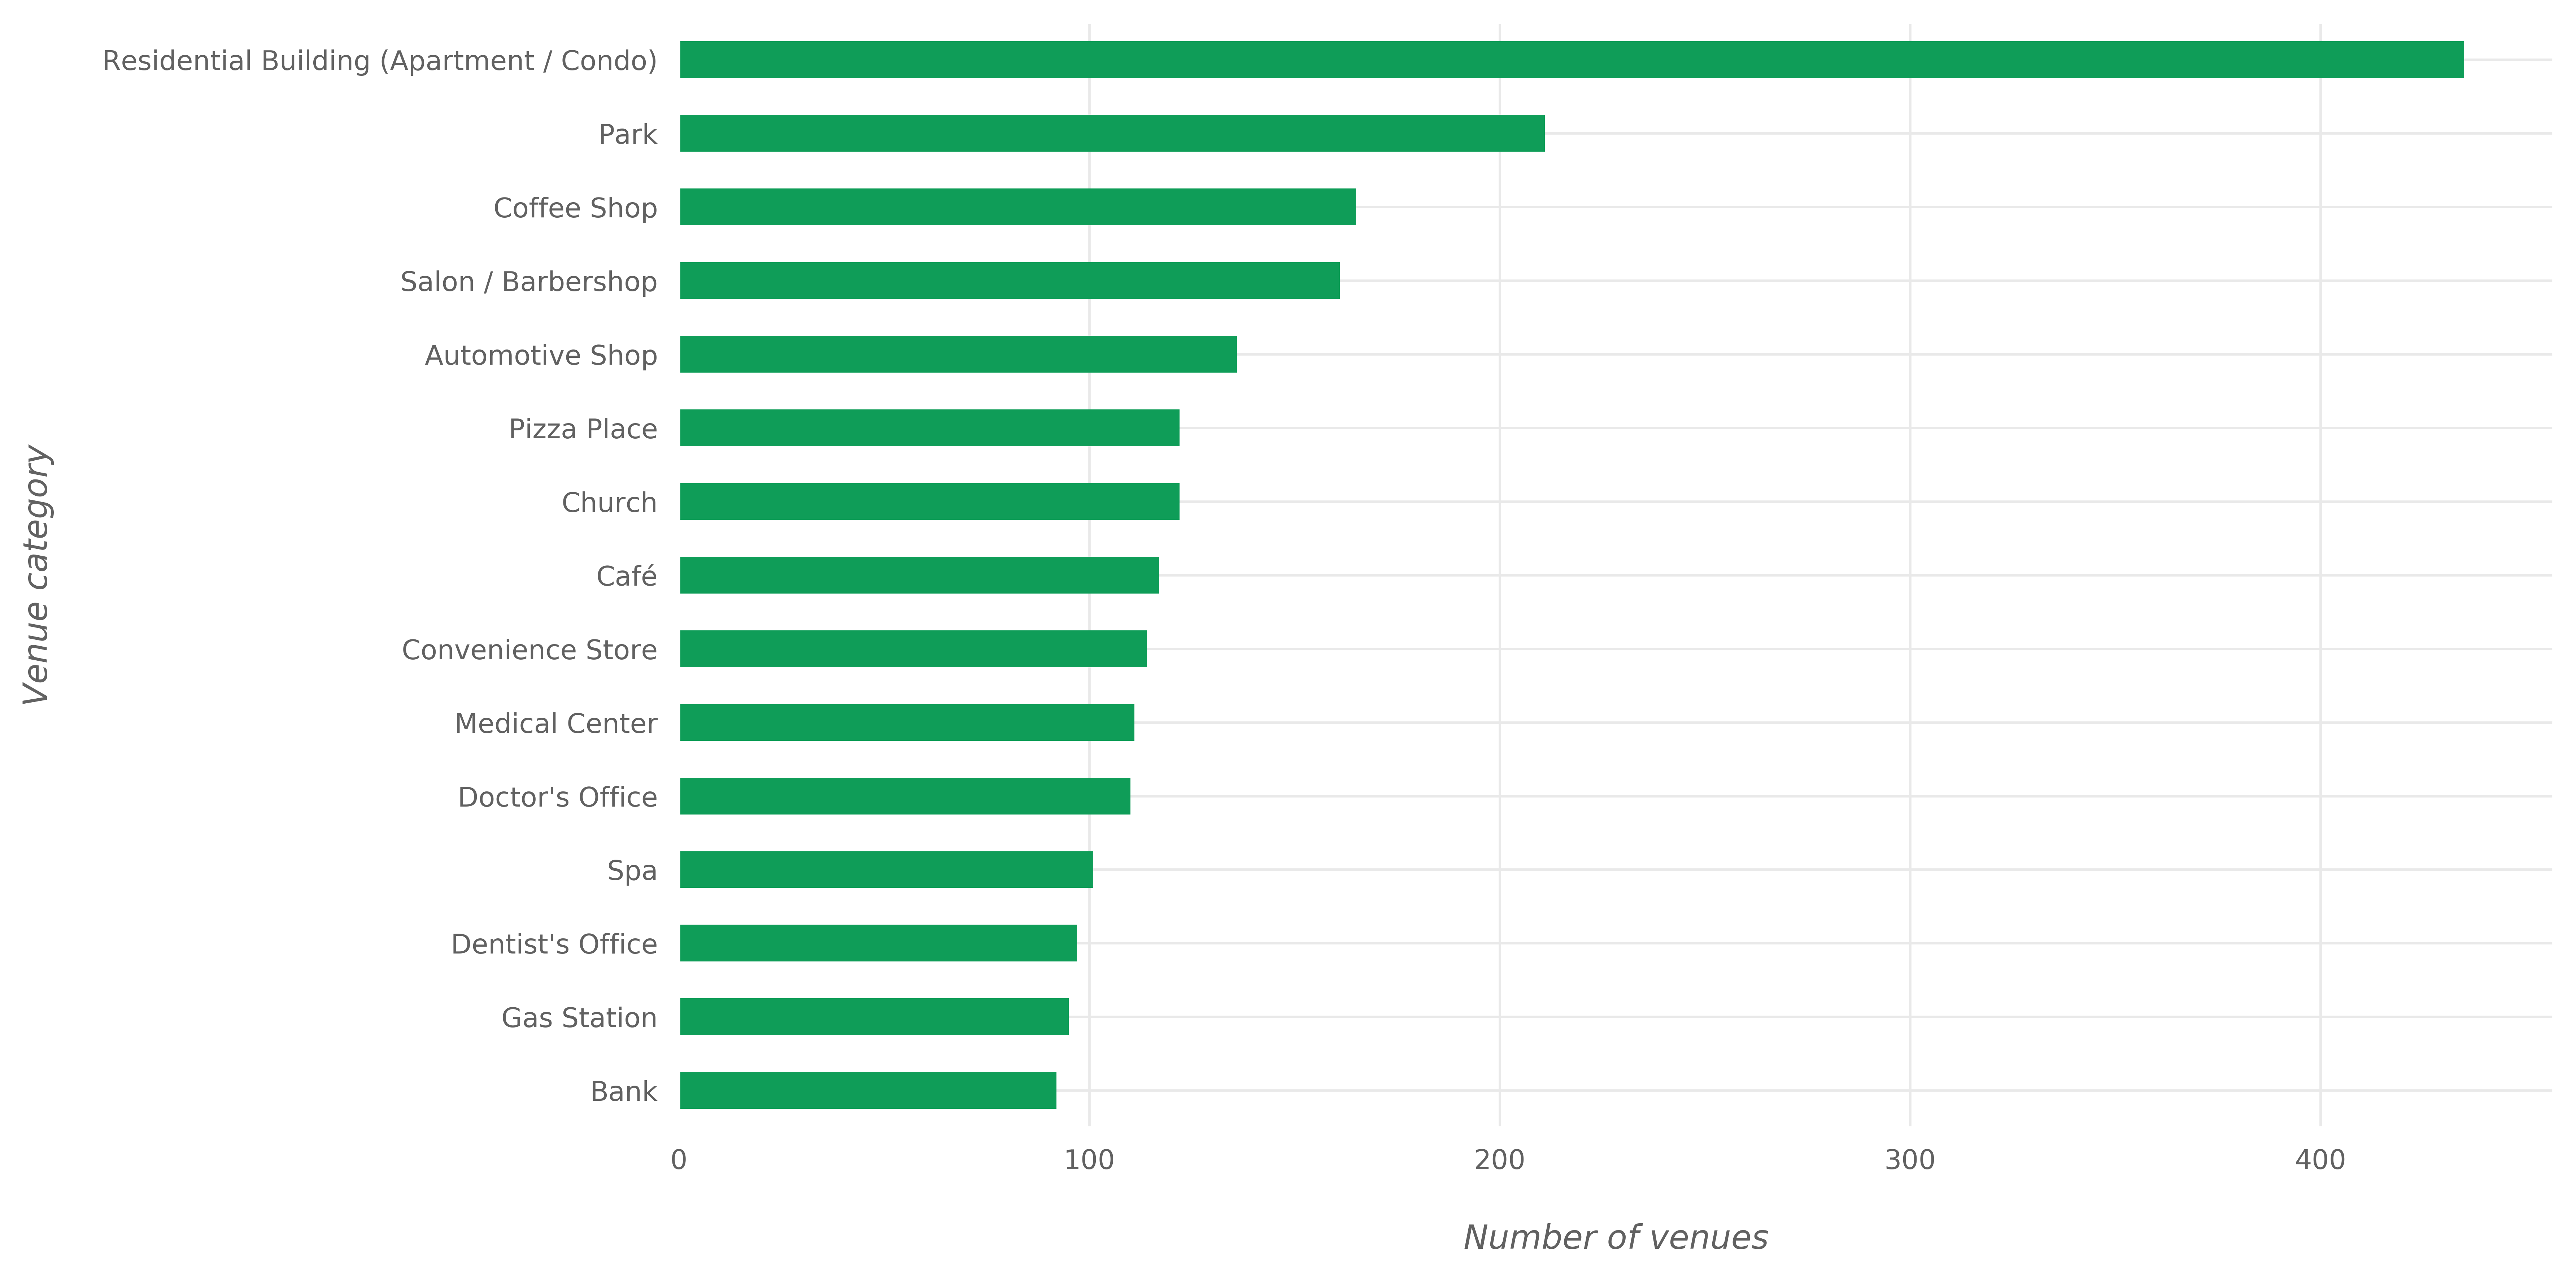

In [67]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

#### Which Venue Categories Exist in More NYC Neighborhoods?

306 neighborhoods in NYC


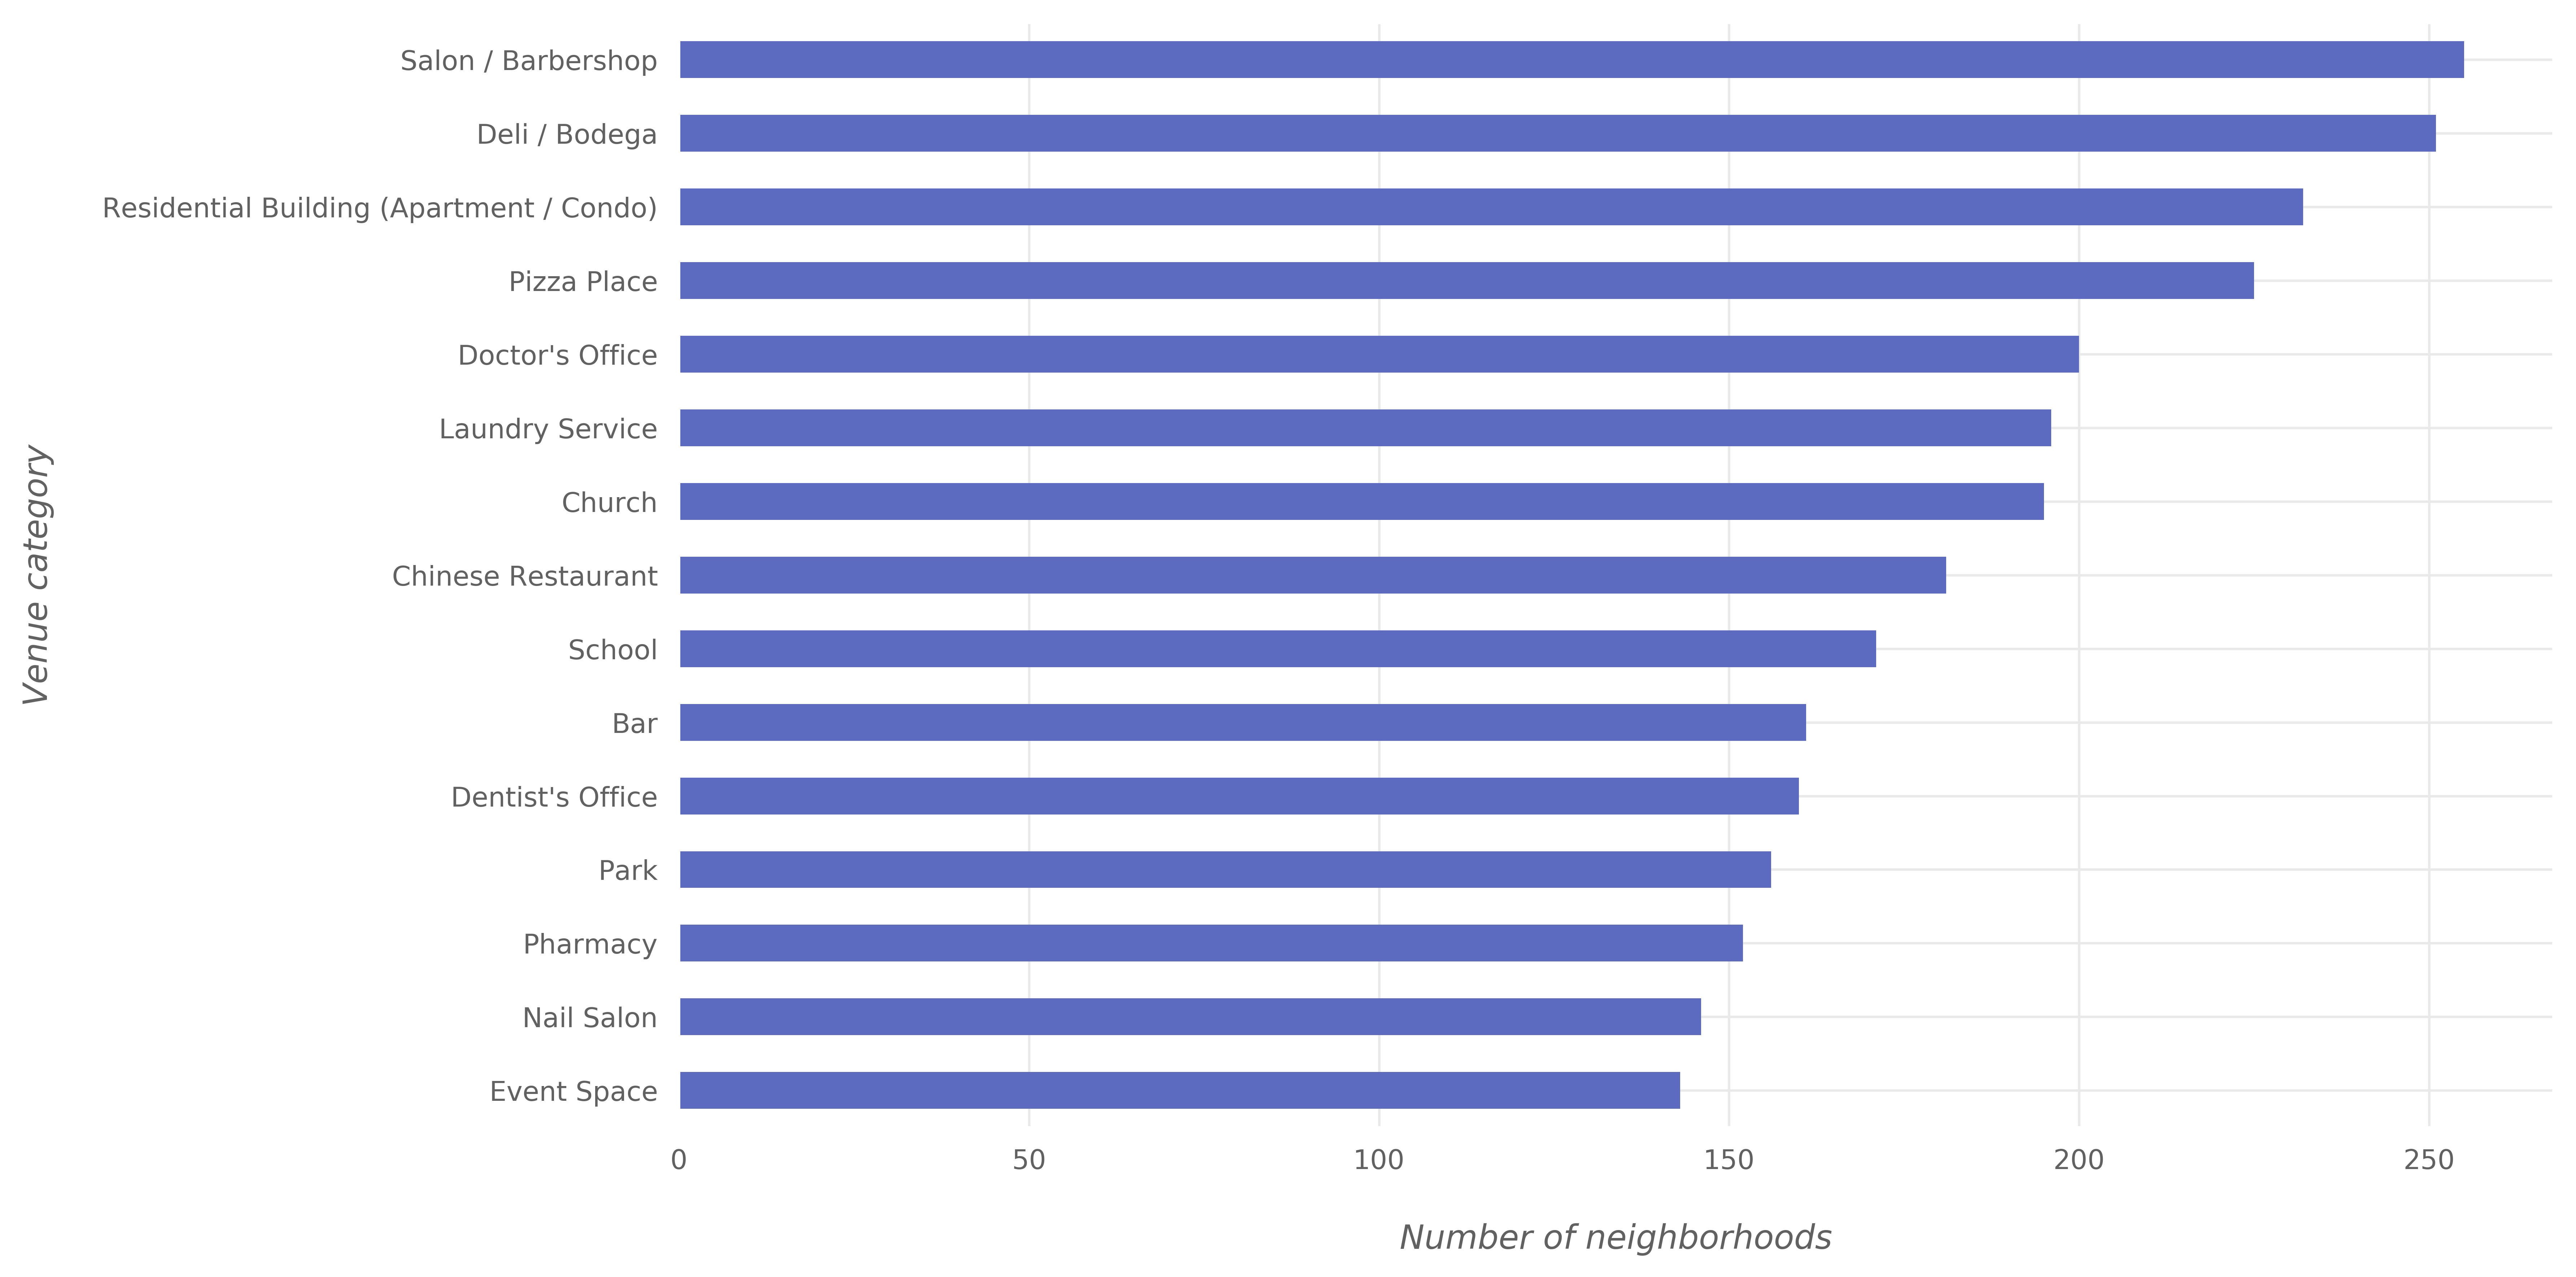

In [68]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = nyc_onehot.groupby('Neighborhood_').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

#### Which Venue Categories Exist in More Toronto Neighborhoods?

102 neighborhoods in Toronto


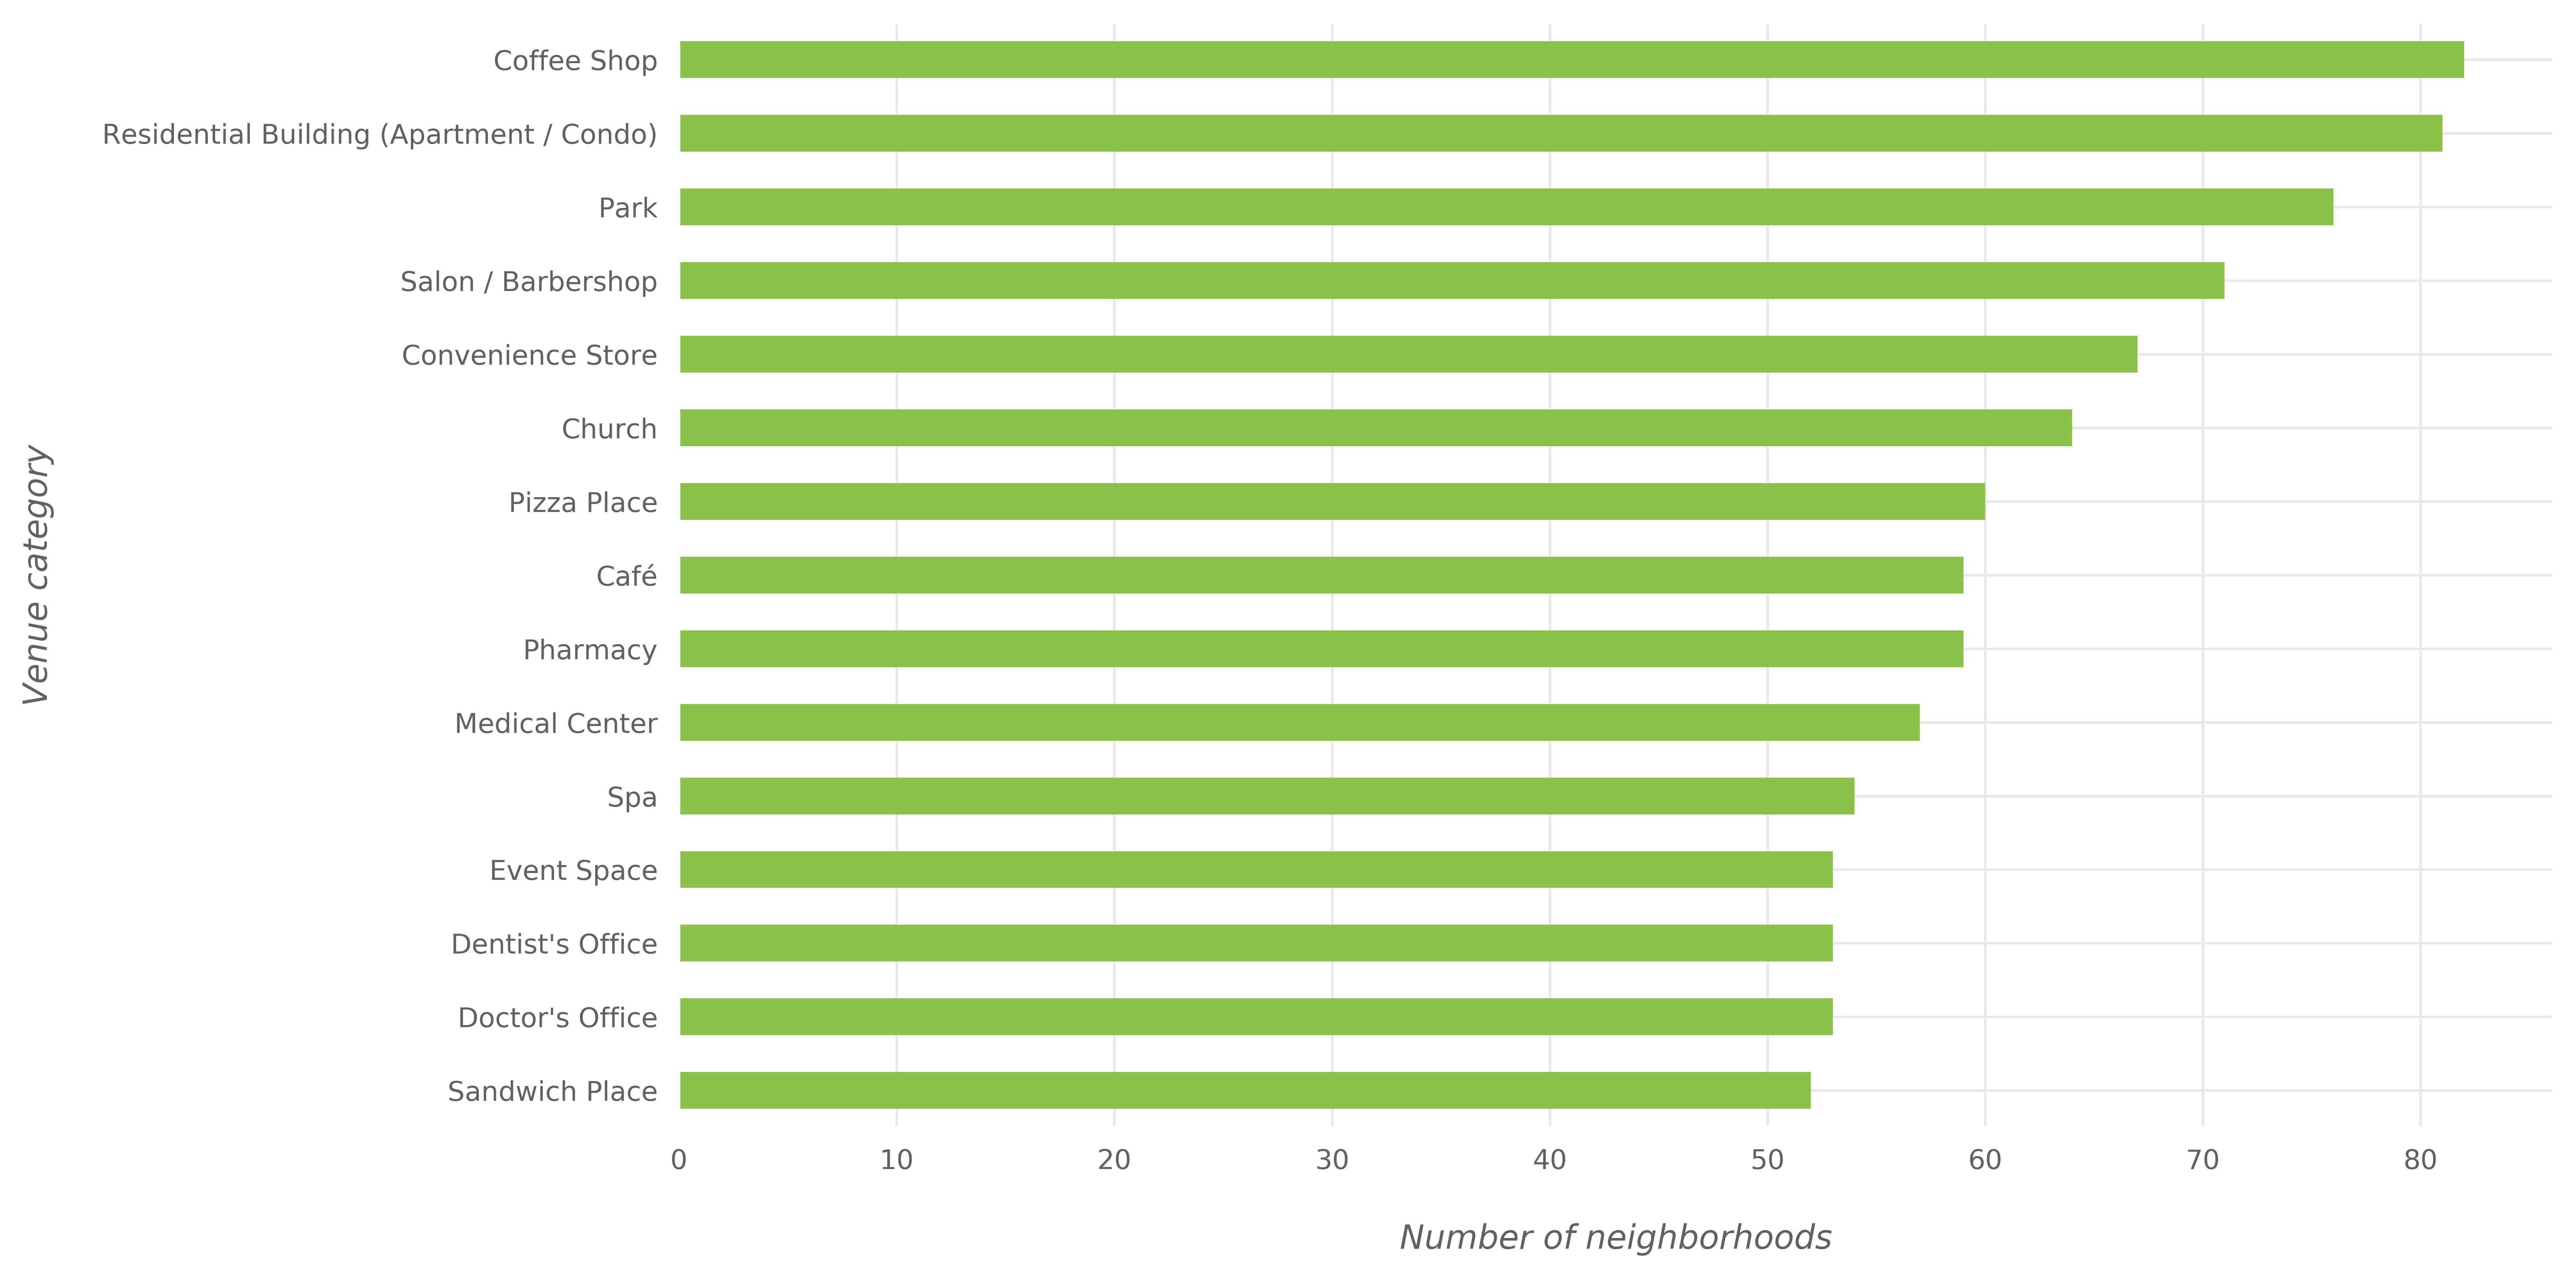

In [69]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

#### Rare Categories in NYC

In [70]:
nyc_bot_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

Count
Venue Category            
Night Market             1
Malay Restaurant         1
Track Stadium            1
City Hall                1
Luggage Store            1
Cruise                   1
Corporate Cafeteria      1
Go Kart Track            1
Czech Restaurant         1
Circus                   1
Sporting Event           1
Summer Camp              1
Hindu Temple             1
Fishing Store            1
Trailer Park             1

#### Rare Categories in Toronto

In [71]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

Count
Venue Category                 
Poutine Place                 1
Distribution Center           1
Indie Theater                 1
Recruiting Agency             1
Surf Spot                     1
Outdoor Sculpture             1
Physical Therapist            1
College Basketball Court      1
Baggage Claim                 1
Salsa Club                    1
Hindu Temple                  1
Kebab Restaurant              1
Cantonese Restaurant          1
Prayer Room                   1
Mini Golf                     1

In [72]:
clmns_nyc_only = set(nyc_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(nyc_grouped.columns))

In [73]:
nyc_grouped_ = nyc_grouped.copy()
nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')
tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [91]:
nyc_tor_grouped.loc[303:308,]

Neighborhood_  Accessories Store  \
303                                        Woodrow_NYC                0.0   
304                                       Woodside_NYC                0.0   
305                                      Yorkville_NYC                0.0   
306                   Adelaide, King, Richmond_Toronto                0.0   
307                                  Agincourt_Toronto                0.0   
308  Agincourt North, L'Amoreaux East, Milliken, St...                0.0   

     Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
303            0.0             0.0                 0.0                0.0   
304            0.0             0.0                 0.0                0.0   
305            0.0             0.0                 0.0                0.0   
306            0.0             0.0                 0.0                0.0   
307            0.0             0.0                 0.0                0.0   
308            0.0             0.0                 0.0                0.0   

     African Restaurant  Airport  Airport Food Court  Airport Gate  \
303                 0.0      0.0                 0.0           0.0   
304                 0.0      0.0                 0.0           0.0   
305                 0.0      0.0                 0.0           0.0   
306                 0.0      0.0                 0.0           0.0   
307                 0.0      0.0                 0.0           0.0   
308                 0.0      0.0                 0.0           0.0   

     Airport Lounge  Airport Service  Airport Terminal  Airport Tram  \
303             0.0              0.0               0.0           0.0   
304             0.0              0.0               0.0           0.0   
305             0.0              0.0               0.0           0.0   
306             0.0              0.0               0.0           0.0   
307             0.0              0.0               0.0           0.0   
308             0.0              0.0               0.0           0.0   

     Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
303                 0.0             0.012658             0.0           0.0   
304                 0.0             0.000000             0.0           0.0   
305                 0.0             0.000000             0.0           0.0   
306                 0.0             0.011111             0.0           0.0   
307                 0.0             0.012821             0.0           0.0   
308                 0.0             0.000000             0.0           0.0   

     Aquarium    Arcade  Arepa Restaurant  Argentinian Restaurant  \
303       0.0  0.000000               0.0                     0.0   
304       0.0  0.000000               0.0                     0.0   
305       0.0  0.000000               0.0                     0.0   
306       0.0  0.000000               0.0                     0.0   
307       0.0  0.012821               0.0                     0.0   
308       0.0  0.000000               0.0                     0.0   

     Art Gallery  Art Museum  Art Studio  Arts & Crafts Store  \
303     0.025316         0.0         0.0             0.000000   
304     0.000000         0.0         0.0             0.000000   
305     0.024096         0.0         0.0             0.000000   
306     0.011111         0.0         0.0             0.000000   
307     0.000000         0.0         0.0             0.012821   
308     0.000000         0.0         0.0             0.016667   

     Arts & Entertainment  Asian Restaurant  Assisted Living  Astrologer  \
303                   0.0          0.000000              0.0         0.0   
304                   0.0          0.000000              0.0         0.0   
305                   0.0          0.000000              0.0         0.0   
306                   0.0          0.022222              0.0         0.0   
307                   0.0          0.000000              0.0         0.0   
308                   

In [92]:
nyc_tor_grouped.shape

(408, 623)

In [75]:
# obtaining the most popular categories for each neighborhood
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood_'] = nyc_tor_grouped['Neighborhood_']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

Neighborhood_     1st Most Common Category  \
0       Allerton_NYC              Laundry Service   
1       Annadale_NYC                  Pizza Place   
2  Arden Heights_NYC  Professional & Other Places   
3      Arlington_NYC                       Church   
4       Arrochar_NYC                Deli / Bodega   

                   2nd Most Common Category 3rd Most Common Category  \
0                             Deli / Bodega       Salon / Barbershop   
1                        Salon / Barbershop            Tattoo Parlor   
2                                      Park                     Food   
3  Residential Building (Apartment / Condo)            Boat or Ferry   
4                           Laundry Service               Nail Salon   

  4th Most Common Category 5th Most Common Category 6th Most Common Category  \
0              Gas Station                 Pharmacy              Pizza Place   
1               Nail Salon      American Restaurant                Pet Store   
2          Doctor's Office                     Pool         Dentist's Office   
3            Deli / Bodega           Hardware Store               Playground   
4              Pizza Place             Dance Studio          Doctor's Office   

  7th Most Common Category  
0                      Spa  
1              Gas Station  
2            Moving Target  
3          Laundry Service  
4       Salon / Barbershop

#### Most Common Venue Categories in both NYC and Toronto

In [76]:
# fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
# nyc_tor_top_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=True) * 100
# ax = nyc_tor_top_vc.head(15).plot(kind='barh', color=pc[12]);
# ax.invert_yaxis()
# plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
# fig.savefig('most-common-ven-nyc-tor.png', dpi=300)

#### Rare Categories in both NYC and Toronto

In [77]:
nyc_tor_bot_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

Count
Venue Category                    
Racecourse                       1
Chinese Breakfast Place          1
Sikh Temple                      1
Airport Food Court               1
Baseball Stadium                 1
Outlet Store                     1
College Technology Building      1
Night Market                     1
Go Kart Track                    1
Castle                           1
Aquarium                         1
Power Plant                      1
Adult Boutique                   1
Souvlaki Shop                    1
Tram Station                     1

### Clustering

In [78]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 0, 2, 0, 4, 2, 1, 2], dtype=int32)

In [79]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood_')

nyc_tor_merged.iloc[300:310] # check the last columns!

Cluster Labels  \
Neighborhood_                                                        
Wingate_NYC                                                      2   
Woodhaven_NYC                                                    2   
Woodlawn_NYC                                                     2   
Woodrow_NYC                                                      1   
Woodside_NYC                                                     2   
Yorkville_NYC                                                    4   
Adelaide, King, Richmond_Toronto                                 1   
Agincourt_Toronto                                                1   
Agincourt North, L'Amoreaux East, Milliken, Ste...               1   
Albion Gardens, Beaumond Heights, Humbergate, J...               2   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Wingate_NYC                                                               Salon / Barbershop   
Woodhaven_NYC                                                             Salon / Barbershop   
Woodlawn_NYC                                                                             Bar   
Woodrow_NYC                                                                             Pool   
Woodside_NYC                                                              Salon / Barbershop   
Yorkville_NYC                                       Residential Building (Apartment / Condo)   
Adelaide, King, Richmond_Toronto                                                 Coffee Shop   
Agincourt_Toronto                                                            Automotive Shop   
Agincourt North, L'Amoreaux East, Milliken, Ste...                        Chinese Restaurant   
Albion Gardens, Beaumond Heights, Humbergate, J...                        Salon / Barbershop   

                                                   2nd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                          School   
Woodhaven_NYC                                                 Deli / Bodega   
Woodlawn_NYC                                                  Deli / Bodega   
Woodrow_NYC                                              Salon / Barbershop   
Woodside_NYC                                                            Bar   
Yorkville_NYC                                               Laundry Service   
Adelaide, King, Richmond_Toronto                                  Hotel Bar   
Agincourt_Toronto                                                       Spa   
Agincourt North, L'Amoreaux East, Milliken, Ste...                   School   
Albion Gardens, Beaumond Heights, Humbergate, J...            Movie Theater   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                            Food   
Woodhaven_NYC                                               Laundry Service   
Woodlawn_NYC                                             Salon / Barbershop   
Woodrow_NYC                                                          School   
Woodside_NYC                                                       Platform   
Yorkville_NYC                                                      Pharmacy   
Adelaide, King, Richmond_Toronto                                       Café   
Agincourt_Toronto                                     General Entertainment   
Agincourt North, L'Amoreaux East, Milliken, Ste...          Doctor's Office   
Albion Gardens, Beaumond Heights, Humbergate, J...         Spiritual Center   

                                                   4th Most Common Category  \
Neighborhood_                                                                 
Wi

#### Examining clusters

Let's see the neighborhoods in each of the five clusters:


##### Cluster 1

In [100]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1.iloc[60:70]

(91, 8)


Cluster Labels  \
Neighborhood_                                                        
Vinegar Hill_NYC                                                 0   
West Village_NYC                                                 0   
Williamsburg_NYC                                                 0   
Bathurst Manor, Downsview North, Wilson Heights...               0   
Bayview Village_Toronto                                          0   
Berczy Park_Toronto                                              0   
Caledonia-Fairbanks_Toronto                                      0   
Cloverdale, Islington, Martin Grove, Princess G...               0   
Downsview Northwest_Toronto                                      0   
Downsview West_Toronto                                           0   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Vinegar Hill_NYC                                                                 Art Gallery   
West Village_NYC                                                                        Taxi   
Williamsburg_NYC                                    Residential Building (Apartment / Condo)   
Bathurst Manor, Downsview North, Wilson Heights...  Residential Building (Apartment / Condo)   
Bayview Village_Toronto                             Residential Building (Apartment / Condo)   
Berczy Park_Toronto                                 Residential Building (Apartment / Condo)   
Caledonia-Fairbanks_Toronto                         Residential Building (Apartment / Condo)   
Cloverdale, Islington, Martin Grove, Princess G...  Residential Building (Apartment / Condo)   
Downsview Northwest_Toronto                         Residential Building (Apartment / Condo)   
Downsview West_Toronto                              Residential Building (Apartment / Condo)   

                                                                    2nd Most Common Category  \
Neighborhood_                                                                                  
Vinegar Hill_NYC                                    Residential Building (Apartment / Condo)   
West Village_NYC                                    Residential Building (Apartment / Condo)   
Williamsburg_NYC                                                                 Pizza Place   
Bathurst Manor, Downsview North, Wilson Heights...                                       Spa   
Bayview Village_Toronto                                                               Church   
Berczy Park_Toronto                                                                  Parking   
Caledonia-Fairbanks_Toronto                                               Salon / Barbershop   
Cloverdale, Islington, Martin Grove, Princess G...                                      Park   
Downsview Northwest_Toronto                                             Caribbean Restaurant   
Downsview West_Toronto                                                                  Park   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Vinegar Hill_NYC                                                Event Space   
West Village_NYC                                            Laundry Service   
Williamsburg_NYC                                         Salon / Barbershop   
Bathurst Manor, Downsview North, Wilson Heights...          Doctor's Office   
Bayview Village_Toronto                                     Doctor's Office   
Berczy Park_Toronto                                   General Entertainment   
Caledonia-Fairbanks_Toronto                                             Bar   
Cloverdale, Islington, Martin Grove, Princess G...                     Café   
Downsview Northwest_Toronto                                           Hotel   
Downsview West_Toronto              

Most common categories among all neighborhoods in this cluster:

##### Cluster 2

In [81]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2

(175, 8)


Cluster Labels  \
Neighborhood_                                                        
Arden Heights_NYC                                                1   
Auburndale_NYC                                                   1   
Bay Ridge_NYC                                                    1   
Bay Terrace, Staten Island_NYC                                   1   
Baychester_NYC                                                   1   
Bayside_NYC                                                      1   
Bayswater_NYC                                                    1   
Beechhurst_NYC                                                   1   
Belle Harbor_NYC                                                 1   
Bellerose_NYC                                                    1   
Bergen Beach_NYC                                                 1   
Blissville_NYC                                                   1   
Boerum Hill_NYC                                                  1   
Borough Park_NYC                                                 1   
Breezy Point_NYC                                                 1   
Brighton Beach_NYC                                               1   
Broad Channel_NYC                                                1   
Broadway Junction_NYC                                            1   
Brookville_NYC                                                   1   
Butler Manor_NYC                                                 1   
Castle Hill_NYC                                                  1   
Charleston_NYC                                                   1   
Chelsea, Staten Island_NYC                                       1   
Chinatown_NYC                                                    1   
City Island_NYC                                                  1   
Civic Center_NYC                                                 1   
Clason Point_NYC                                                 1   
Clifton_NYC                                                      1   
Country Club_NYC                                                 1   
Downtown_NYC                                                     1   
Dumbo_NYC                                                        1   
Eastchester_NYC                                                  1   
Edgemere_NYC                                                     1   
Edgewater Park_NYC                                               1   
Eltingville_NYC                                                  1   
Fieldston_NYC                                                    1   
Financial District_NYC                                           1   
Flatiron_NYC                                                     1   
Flushing_NYC                                                     1   
Fordham_NYC                                                      1   
Fulton Ferry_NYC                                                 1   
Gerritsen Beach_NYC                                              1   
Glen Oaks_NYC                                                    1   
Gowanus_NYC                                                      1   
Graniteville_NYC                                                 1   
Grant City_NYC                                                   1   
Grasmere_NYC                                                     1   
Gravesend_NYC                                                    1   
Hillcrest_NYC                                                    1   
Howard Beach_NYC                                                 1   
Howland Hook_NYC                                                 1   
Hudson Yards_NYC                                                 1   
Huguenot_NYC                                                     1   
Hunts Point_NYC                                                  1   
Jamaica Estates_NYC                                              1   
Kensington_NYC                                                

##### Cluster 3

In [102]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(81, 8)


Cluster Labels  \
Neighborhood_                                                        
Wingate_NYC                                                      2   
Woodhaven_NYC                                                    2   
Woodlawn_NYC                                                     2   
Woodside_NYC                                                     2   
Albion Gardens, Beaumond Heights, Humbergate, J...               2   

                                                   1st Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                              Salon / Barbershop   
Woodhaven_NYC                                            Salon / Barbershop   
Woodlawn_NYC                                                            Bar   
Woodside_NYC                                             Salon / Barbershop   
Albion Gardens, Beaumond Heights, Humbergate, J...       Salon / Barbershop   

                                                   2nd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                          School   
Woodhaven_NYC                                                 Deli / Bodega   
Woodlawn_NYC                                                  Deli / Bodega   
Woodside_NYC                                                            Bar   
Albion Gardens, Beaumond Heights, Humbergate, J...            Movie Theater   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                            Food   
Woodhaven_NYC                                               Laundry Service   
Woodlawn_NYC                                             Salon / Barbershop   
Woodside_NYC                                                       Platform   
Albion Gardens, Beaumond Heights, Humbergate, J...         Spiritual Center   

                                                   4th Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                       Nightclub   
Woodhaven_NYC                                            Chinese Restaurant   
Woodlawn_NYC                                                         Garden   
Woodside_NYC                                         Thrift / Vintage Store   
Albion Gardens, Beaumond Heights, Humbergate, J...              Pizza Place   

                                                   5th Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                   Deli / Bodega   
Woodhaven_NYC                                                   Pizza Place   
Woodlawn_NYC                                              Food & Drink Shop   
Woodside_NYC                                             Miscellaneous Shop   
Albion Gardens, Beaumond Heights, Humbergate, J...                     Farm   

                                                                    6th Most Common Category  \
Neighborhood_                                                                                  
Wingate_NYC                                         Residential Building (Apartment / Condo)   
Woodhaven_NYC                                                                     Hookah Bar   
Woodlawn_NYC                                        Residential Building (Apartment / Condo)   
Woodside_NYC                                                                   Deli / Bodega   
Albion Gardens, Beaumond Heights, Humbergate, J...                               Art Gallery   

                                                   7th Most Common Category  
Neighborhood_                           

##### Cluster 4

In [83]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4

(33, 8)


Cluster Labels  \
Neighborhood_                                
Bloomfield_NYC                           3   
Brooklyn Heights_NYC                     3   
Bulls Head_NYC                           3   
Castleton Corners_NYC                    3   
Concord_NYC                              3   
Dongan Hills_NYC                         3   
Dyker Heights_NYC                        3   
Egbertville_NYC                          3   
Emerson Hill_NYC                         3   
Forest Hills_NYC                         3   
Fort Hamilton_NYC                        3   
Georgetown_NYC                           3   
Glendale_NYC                             3   
Gramercy_NYC                             3   
Greenridge_NYC                           3   
Heartland Village_NYC                    3   
Holliswood_NYC                           3   
Lindenwood_NYC                           3   
Madison_NYC                              3   
Manhattan Terrace_NYC                    3   
Morris Park_NYC                          3   
Murray Hill, Manhattan_NYC               3   
New Springville_NYC                      3   
Norwood_NYC                              3   
Oakwood_NYC                              3   
Pelham Gardens_NYC                       3   
Pelham Parkway_NYC                       3   
Pomonok_NYC                              3   
Rockaway Park_NYC                        3   
Schuylerville_NYC                        3   
Starrett City_NYC                        3   
Tudor City_NYC                           3   
Upper East Side_NYC                      3   

                                            1st Most Common Category  \
Neighborhood_                                                          
Bloomfield_NYC                                       Doctor's Office   
Brooklyn Heights_NYC                                 Doctor's Office   
Bulls Head_NYC                                       Doctor's Office   
Castleton Corners_NYC                                Doctor's Office   
Concord_NYC                                          Doctor's Office   
Dongan Hills_NYC                                       Deli / Bodega   
Dyker Heights_NYC                                    Doctor's Office   
Egbertville_NYC                                      Doctor's Office   
Emerson Hill_NYC                                     Doctor's Office   
Forest Hills_NYC                                    Dentist's Office   
Fort Hamilton_NYC                                    Doctor's Office   
Georgetown_NYC                                       Doctor's Office   
Glendale_NYC                                         Doctor's Office   
Gramercy_NYC                                                    Taxi   
Greenridge_NYC                                       Doctor's Office   
Heartland Village_NYC                                Doctor's Office   
Holliswood_NYC                                       Doctor's Office   
Lindenwood_NYC                                       Doctor's Office   
Madison_NYC                                          Doctor's Office   
Manhattan Terrace_NYC                                Doctor's Office   
Morris Park_NYC                                      Doctor's Office   
Murray Hill, Manhattan_NYC  Residential Building (Apartment / Condo)   
New Springville_NYC                                  Doctor's Office   
Norwood_NYC                                          Doctor's Office   
Oakwood_NYC                                          Doctor's Office   
Pelham Gardens_NYC                                   Doctor's Office   
Pelham Parkway_NYC                                   Doctor's Office   
Pomonok_NYC                                          Doctor's Office   
Rockaway Park_NYC                                    Doctor's Office   
Schuylerville_NYC                                    Doctor's Office   
Starrett City_NYC                                    Doctor's Office   
Tudor City_NYC                           

##### Cluster 5

In [84]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5

(28, 8)


Cluster Labels  \
Neighborhood_                                                        
Astoria_NYC                                                      4   
Bay Terrace, Queens_NYC                                          4   
Bedford Park_NYC                                                 4   
Ditmas Park_NYC                                                  4   
Flatbush_NYC                                                     4   
Forest Hills Gardens_NYC                                         4   
Jackson Heights_NYC                                              4   
Lefrak City_NYC                                                  4   
Lower East Side_NYC                                              4   
Mott Haven_NYC                                                   4   
Prospect Park South_NYC                                          4   
Rego Park_NYC                                                    4   
Riverdale_NYC                                                    4   
Rochdale_NYC                                                     4   
Spuyten Duyvil_NYC                                               4   
Stuyvesant Town_NYC                                              4   
Upper West Side_NYC                                              4   
Washington Heights_NYC                                           4   
Yorkville_NYC                                                    4   
Brockton, Exhibition Place, Parkdale Village_To...               4   
Church and Wellesley_Toronto                                     4   
Davisville North_Toronto                                         4   
Deer Park, Forest Hill SE, Rathnelly, South Hil...               4   
Humber Bay, King's Mill Park, Kingsway Park Sou...               4   
The Annex, North Midtown, Yorkville_Toronto                      4   
Victoria Village_Toronto                                         4   
Willowdale West_Toronto                                          4   
York Mills West_Toronto                                          4   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Astoria_NYC                                         Residential Building (Apartment / Condo)   
Bay Terrace, Queens_NYC                             Residential Building (Apartment / Condo)   
Bedford Park_NYC                                    Residential Building (Apartment / Condo)   
Ditmas Park_NYC                                     Residential Building (Apartment / Condo)   
Flatbush_NYC                                        Residential Building (Apartment / Condo)   
Forest Hills Gardens_NYC                            Residential Building (Apartment / Condo)   
Jackson Heights_NYC                                 Residential Building (Apartment / Condo)   
Lefrak City_NYC                                     Residential Building (Apartment / Condo)   
Lower East Side_NYC                                 Residential Building (Apartment / Condo)   
Mott Haven_NYC                                      Residential Building (Apartment / Condo)   
Prospect Park South_NYC                             Residential Building (Apartment / Condo)   
Rego Park_NYC                                       Residential Building (Apartment / Condo)   
Riverdale_NYC                                       Residential Building (Apartment / Condo)   
Rochdale_NYC                                        Residential Building (Apartment / Condo)   
Spuyten Duyvil_NYC                                  Residential Building (Apartment / Condo)   
Stuyvesant Town_NYC                                 Residential Building (Apartment / Condo)   
Upper West Side_NYC                                 Residential Building (Apartment / Condo)   
Washington Heights_NYC                              Residential Building (Apartment / Condo)   
Yorkville_NYC                  

In [110]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(nyc_venues[nyc_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100


In [112]:
# clust_cats[0]

In [113]:
tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [114]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

In [115]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

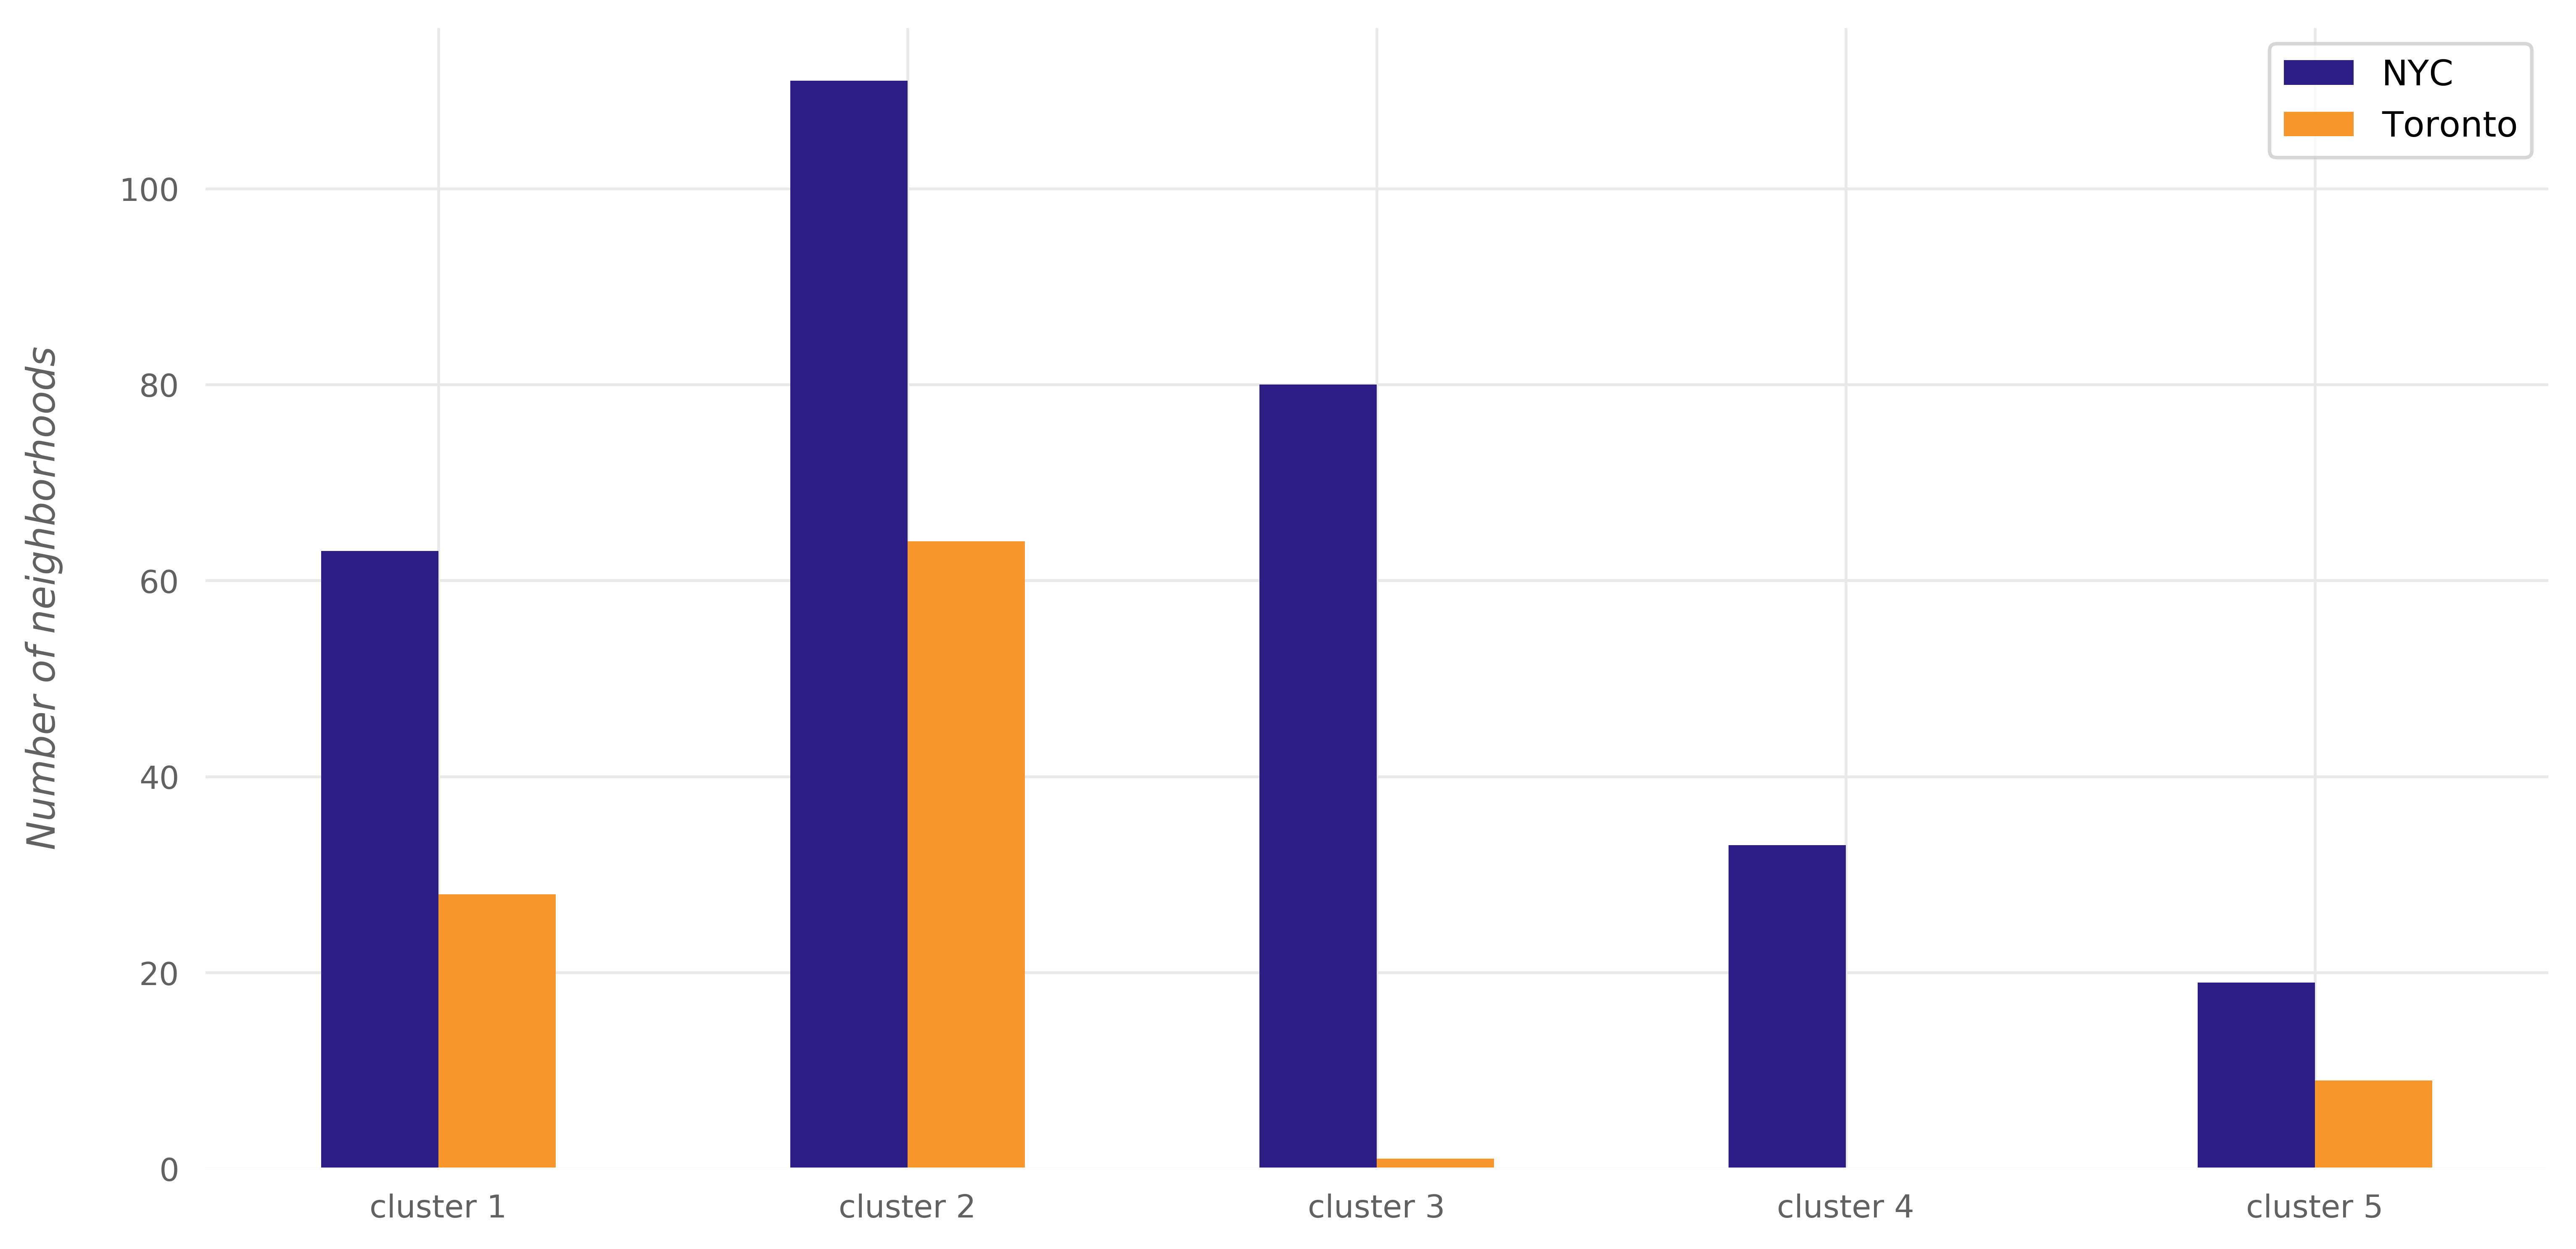

In [116]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NYC': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)